In [1]:
import alpaca_trade_api as alpaca
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from pandas.plotting import lag_plot 
import plotly.express as px
import plotly.graph_objects as pg
from plotly import tools
from plotly.offline import iplot
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
sns.set(font_scale= .7)
from pylab import rcParams

In [2]:
custom_template = {
    "layout": pg.Layout(
        font={
            "family": "Courier New",
            "size": 11,
            "color": "#707070",
        },
        title={
            "font": {
                "family": "Courier New",
                "size": 15,
                "color": "#1f1f1f",
            },
        },
        plot_bgcolor="#ffffff",
        paper_bgcolor="#ffffff",
        colorway=px.colors.qualitative.G10,
    )
}
def format_title(title, subtitle=None, subtitle_font_size=12):
    title = f'<b>{title}</b>'
    if not subtitle:
        return title
    subtitle = f'<span style="font-size: {subtitle_font_size}px;">{subtitle}</span>'
    return f'{title}<br>{subtitle}'

In [3]:
class PortfolioAnalyzer:
    
    def __init__(self, ticker, start_date, end_date, weights=None):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        if weights is not None:
            self.weights = np.array(weights)
            print(weights)
        else:
            self.weights = self.generate_random_weights()
            
    def generate_random_weights(self):
        # Generate random weights that add up to 1 and round to 1 digit
        weights = [round(random.random(), 1) for _ in range(len(self.ticker))]
        total_weight = sum(weights)
        weights = np.array([round(weight / total_weight, 1) for weight in weights])
        return weights
    
    def get_price(self, pivot=False):
        # alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')
        # timeframe = "1Day"
        # portfolio = pd.DataFrame(alpaca_api.get_bars(self.ticker, timeframe, self.start_date, self.end_date).df)
        if pivot:
            df = yf.download(self.ticker, start = self.start_date, end = self.end_date, group_by='Ticker')
            portfolio= df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
        else:
            portfolio= yf.download(self.ticker, start = self.start_date, end = self.end_date)
        return portfolio
    
    def daily_returns(self, pivot=False, adj=False, cum=False):
        df = self.get_price(pivot)
        if adj:
            daily_returns = df["Adj Close"].pct_change().dropna()
        else:
            daily_returns = df["Close"].pct_change().dropna()
        if cum:
            daily_returns = (1 + daily_returns).cumprod() - 1
        return daily_returns
    
    def log_returns(self,pivot=False, adj=False, cum=False):
        daily_returns = self.daily_returns(pivot, adj, cum)
        log_returns = np.log(1 + daily_returns)
        return log_returns
    
    def volatility(self, pivot=True,adj=False, cum=False):
        data = self.get_price(pivot)
        TRADING_DAYS = 252
        if adj:
            closePrice = data[['Adj Close', 'Ticker']].reset_index()
        else:
            closePrice = data[['Close', 'Ticker']].reset_index()
        closePriceTable = closePrice.pivot(index='Date', columns='Ticker', values='Adj Close')
        returns_portfolio = np.log(closePriceTable / closePriceTable.shift(1))
        returns_portfolio.fillna(0, inplace=True)
        volatility_portfolio = returns_portfolio.rolling(window=TRADING_DAYS).std() * np.sqrt(TRADING_DAYS)
        volatility_portfolio = pd.melt(volatility_portfolio.reset_index(), id_vars='Date', var_name='Ticker', value_name='Value').rename(columns={'index': 'Date'})
        return volatility_portfolio
    
    def corr_matrix(self, pivot=False,plot=False, cum=False, template=custom_template):
        returns = self.daily_returns()
        if cum:
            returns = self.daily_returns(cum)
        corr_matrix = returns.corr()
        if plot:
            fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='tempo', 
                            template=custom_template, title=format_title("Correlation Matrix Of Stock Portfolio",
                                                                         'GOOG and MSFT have the highest correlation of 0.75'))
            fig.show()
        return corr_matrix
    
    def cov_matrix(self, pivot=False,plot=False, cum=False, template=custom_template):
        returns = self.daily_returns()
        if cum:
            returns = self.daily_returns(cum)
        cov_matrix = returns.cov()
        if plot:
            fig = px.imshow(cov_matrix, text_auto=True, color_continuous_scale='tempo', 
                            template=custom_template, title=format_title("Covariance Matrix Of Stock Portfolio",
                                                                         'GOOG and MSFT have the highest correlation of 0.75'))
            fig.show()
        return cov_matrix
    
    def portfolio_returns(self, pivot=False,adj = False, cum = False):
        returns = self.daily_returns(pivot, adj, cum)
        portfolio_returns = (returns*self.weights).sum(axis=1)
        return portfolio_returns
    
    def risk_return(self, pivot=False, adj = False, template = custom_template):
        returns = self.daily_returns(adj).mul(100)
        trading_days  = 252
        summary = returns.describe().T.loc[:,["mean","std"]]
        summary["mean"] = round(summary["mean"]*trading_days,2) # Multiply by number of trading days
        summary["std"]  = round(summary["std"]*np.sqrt(trading_days),2)
        summary.rename(columns = {'mean':'% Return', 'std':'Risk'}, inplace = True) 
        return summary
    


In [4]:
ticker = ["AAPL", "MSFT","GOOG","INTC","NVDA"]
start_date = "2016-01-01"
end_date = "2023-12-31"
weight= [0.2]*5
portfolio= PortfolioAnalyzer(ticker, start_date, end_date, weight)
data=portfolio.get_price(pivot=True)
data.to_pickle('./PortfolioCloseP.pkl')
data.head(5)

[0.2, 0.2, 0.2, 0.2, 0.2]


[*********************100%%**********************]  5 of 5 completed


Price      Ticker       Open       High        Low      Close  Adj Close  \
Date                                                                       
2016-01-04   AAPL  25.652500  26.342501  25.500000  26.337500  23.946922   
2016-01-04   GOOG  37.150002  37.202999  36.562901  37.091999  37.091999   
2016-01-04   INTC  33.880001  34.009998  33.459999  33.990002  27.142982   
2016-01-04   MSFT  54.320000  54.799999  53.389999  54.799999  48.608997   
2016-01-04   NVDA   8.072500   8.145000   8.010000   8.092500   7.899905   

Price          Volume  
Date                   
2016-01-04  270597600  
2016-01-04   65456000  
2016-01-04   27882200  
2016-01-04   53778000  
2016-01-04   35807600

In [5]:
for item in data.columns :
    if data[item].isnull().values.any() :
        print('stock price data of '+item+' still has NaN')
print("END OF CHECKING. NO NA REMAINING")

END OF CHECKING. NO NA REMAINING


<div class="alert alert-block alert-info">
<b>Closing Price:</b> While Nvidia and Microsoft are two of the market's hottest artificial intelligence stocks. Nvidia's high-end GPUs are used to process complex AI tasks in data centers, while Microsoft is a leading investor in OpenAI. Based on the plot bleow, despite the sharp drop in the early years of 2022, over the past few years, Nvidia's stock has soared more than 600% while Microsoft's stock has rallied over 70%, as other tech stocks remains less volatile. The question arosed: will it continue to outperform Microsoft over the next few years?
</div>

In [6]:
fig1 = px.line(data, x=data.index, 
              y='Adj Close', 
              color='Ticker', 
              title= format_title("Stock Market Performance From 2016-2023",
                                  "Nvidia's vast potential in AI has made Wall Street Bullish starting from 2023 "),
              template=custom_template)
fig1.show()

In [7]:
fig2 = px.area(data, x=data.index, y='Adj Close', color='Ticker',
              facet_col='Ticker',
              labels={ 'Close':'Closing Price', 'Ticker':'Company'},
              title=format_title('Stock Prices for Apple,Google,Intel,Microsoft,and Nividia'),
              template=custom_template)
fig2.show()

<div class="alert alert-block alert-info">
<b>Portfolio Daily Returns:</b> Based on an equal weighted portfolio, the following plot shows the percentage change in stock price compared to the previous day. The high variance in the early months of 2020 shown a loss in market confidence and indicating the uncertainty of the 5 included tech stocks. 
</div>

In [8]:
dailyR= portfolio.portfolio_returns(pivot=False)
fig3=px.line(dailyR, template = custom_template, title=format_title('Portfolio Daily Returns Based on Equal Weighted Portfolio'))
fig3.update_layout(showlegend=False)
fig3.show()

[*********************100%%**********************]  5 of 5 completed


<div class="alert alert-block alert-info">
<b>Volatility:</b> Volatility is the degree of variation of trading prices over-time. We can see that Nvidia's shares are very volatile and over the last years have had many moves greater than 5%. In a bigger picture, there is a spike in volatility starting from 2020 in the early months of 2022.
</div>

In [9]:
volatility= portfolio.volatility(adj=True)
fig = px.line(volatility,x=volatility.Date, y='Value', color='Ticker',
              title=format_title('Annualized Volatility For Portfolio',
                                 'NVDA with the highest annulized volatility relative to the others indicates higher risk '), 
                                 template= custom_template
              )
fig.show()

[*********************100%%**********************]  5 of 5 completed


<div class="alert alert-block alert-info">
<b>Portfolio Covariance:</b> To measure the directional relationship between two stock prices, the covariance matrix is shown below. Although the slightly positive covariance means that assets generally move in the same direction, but there is no clear directional relationship between two assets being measured. 
</div>

In [11]:
portfolio.cov_matrix(plot=True)

[*********************100%%**********************]  5 of 5 completed


Ticker      AAPL      GOOG      INTC      MSFT      NVDA
Ticker                                                  
AAPL    0.000341  0.000216  0.000217  0.000232  0.000336
GOOG    0.000216  0.000322  0.000204  0.000236  0.000323
INTC    0.000217  0.000204  0.000471  0.000224  0.000348
MSFT    0.000232  0.000236  0.000224  0.000307  0.000348
NVDA    0.000336  0.000323  0.000348  0.000348  0.000976

In [10]:
portfolio.corr_matrix(plot=True)

[*********************100%%**********************]  5 of 5 completed


Ticker      AAPL      GOOG      INTC      MSFT      NVDA
Ticker                                                  
AAPL    1.000000  0.652000  0.541994  0.715481  0.582502
GOOG    0.652000  1.000000  0.523124  0.752714  0.576876
INTC    0.541994  0.523124  1.000000  0.588747  0.513255
MSFT    0.715481  0.752714  0.588747  1.000000  0.635623
NVDA    0.582502  0.576876  0.513255  0.635623  1.000000

In [12]:
nvda=data.loc[data['Ticker'] == 'NVDA']
nvda

Price      Ticker        Open        High         Low       Close   Adj Close  \
Date                                                                            
2016-01-04   NVDA    8.072500    8.145000    8.010000    8.092500    7.899905   
2016-01-05   NVDA    8.245000    8.360000    8.125000    8.222500    8.026810   
2016-01-06   NVDA    8.087500    8.125000    7.790000    7.882500    7.694903   
2016-01-07   NVDA    7.685000    7.737500    7.470000    7.570000    7.389841   
2016-01-08   NVDA    7.667500    7.675000    7.392500    7.407500    7.231209   
...           ...         ...         ...         ...         ...         ...   
2023-12-22   NVDA  491.950012  493.829987  484.670013  488.299988  488.277069   
2023-12-26   NVDA  489.679993  496.000000  489.600006  492.790009  492.766907   
2023-12-27   NVDA  495.109985  496.799988  490.850006  494.170013  494.146820   
2023-12-28   NVDA  496.429993  498.839996  494.119995  495.220001  495.196777   
2023-12-29   NVDA  498.130005  499.970001  487.510010  495.220001  495.196777   

Price         Volume  
Date                  
2016-01-04  35807600  
2016-01-05  49027200  
2016-01-06  44934400  
2016-01-07  64530400  
2016-01-08  39847200  
...              ...  
2023-12-22  25213900  
2023-12-26  24420000  
2023-12-27  23364800  
2023-12-28  24658700  
2023-12-29  38869000  

[2012 rows x 7 columns]

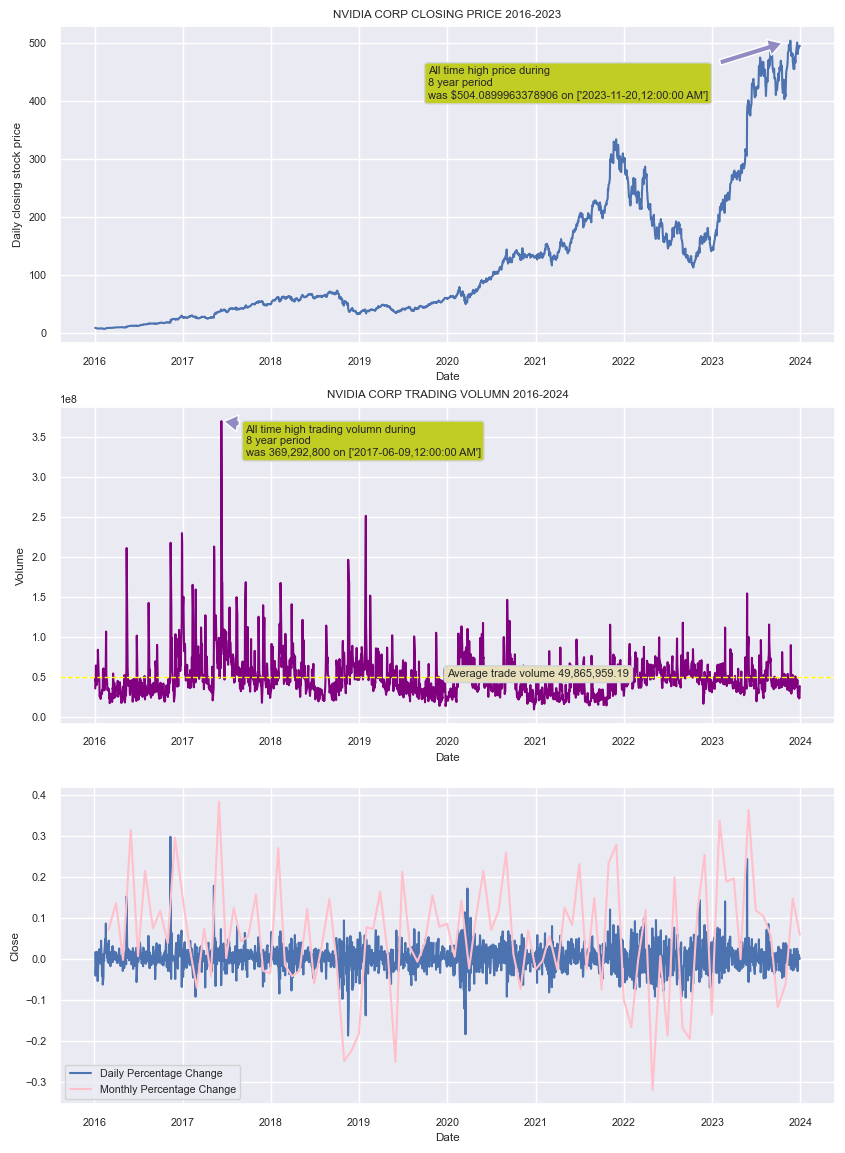

In [13]:
# visualize the data
plt.rcParams['font.size'] = 8
fig, axes = plt.subplots(3,1,figsize=(10,14))
sns.lineplot(x=nvda.index,y=nvda.Close, ax=axes[0]).set_title('NVIDIA CORP CLOSING PRICE 2016-2023')
axes[0].set_ylabel("Daily closing stock price")
high = nvda['Close'].max()
dateHigh= nvda[nvda['Close'] == high].index
axes[0].annotate(f"All time high price during\n8 year period\nwas ${high} on {dateHigh.strftime('%Y-%m-%d,%r').values}", 
                 xy=(dateHigh,high),xytext=(dateHigh+pd.DateOffset(days=-1500) ,high-100),
                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))
sns.lineplot(x=nvda.index,y=nvda.Volume,ax=axes[1], color='purple').set_title('NVIDIA CORP TRADING VOLUMN 2016-2024')
highVal = nvda['Volume'].max()
dateHighVal= nvda[nvda['Volume'] == highVal].index
axes[1].annotate(f"All time high trading volumn during\n8 year period\nwas {highVal:,} on {dateHighVal.strftime('%Y-%m-%d,%r').values}", 
                 xy=(dateHighVal,highVal),xytext=(dateHighVal+pd.DateOffset(days=100)  ,highVal-9**8),
                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))
axes[1].axhline(y=nvda['Volume'].mean(), linestyle='--',lw=1, color='yellow')
axes[1].annotate(f"Average trade volume {round(nvda['Volume'].mean(),2):,}", 
                xy=(nvda.index.mean(),nvda.Volume.mean()),xytext=(nvda.index.mean(),nvda.Volume.mean()),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )

sns.lineplot(x=nvda.index, y=nvda.Close.pct_change(fill_method='bfill'), label='Daily Percentage Change',ax=axes[2])
#monthly percent change of stock closing price based on the last day of each month 
monthR= nvda.resample('BM').apply(lambda x:x[-1])
#highValM= monthR.Close.pct_change(fill_method='bfill').abs().max()
#dateHighValM= monthR[monthR['Close'].pct_change()== highValM].index
sns.lineplot(x=monthR.index, y=monthR.Close.pct_change(fill_method='bfill'), label='Monthly Percentage Change',ax=axes[2], color='pink')
#axes[2].annotate(f"All time highest percentage change during\n8 year period\nwas {highValM:,} on {dateHighValM.strftime('%Y-%m-%d,%r').values}", 
#                xy=(dateHighValM,highValM),xytext=(dateHighValM+pd.DateOffset(days=100) ,highValM-5),
#                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
#                arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))

plt.show()

In [15]:
def check_stationarity(series, outprint=True):
    '''Test the null hypothesis of non-stationary time series data,
    if the pvalue is smaller than 0.05 threshold, reject the hypothesis'''
    if len(series) < 10:  # Adjust the threshold as needed
        print("Series is too short to perform ADF test.")
        return None
    
    result = adfuller(series, autolag='AIC', regression='ct')
    if outprint:
        print('ADF Statistic: %f' % result[0])
        print(f'p-value: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

        if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
        
    return result

In [16]:
for tickerS in data['Ticker'].unique().tolist():
    df= data.loc[data['Ticker'] == tickerS]
    print(tickerS)
    rawClose= check_stationarity(df.Close)

AAPL
ADF Statistic: -2.635799
p-value: 0.26369234652626294
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary
GOOG
ADF Statistic: -1.698788
p-value: 0.7514030086472137
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary
INTC
ADF Statistic: -2.229707
p-value: 0.4731514103781132
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary
MSFT
ADF Statistic: -2.461738
p-value: 0.3473481270098059
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary
NVDA
ADF Statistic: -0.231851
p-value: 0.9909484519453114
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary


In [17]:
def decomposition(df, periodList):
    adfR={}
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    color_index = 0
    for ticker in data['Ticker'].unique().tolist():
        df= data.loc[data['Ticker'] == ticker]
        closingP= df.Close
        adfR[ticker] = {}  # Nested dictionary for each ticker
        fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(12,8))
        for row,period in enumerate(periodList):
            modelList=['additive','multiplicative']
            for col, model in enumerate(modelList):
                # decompistion instance
                result_decom = seasonal_decompose(closingP, model=model, 
                                                period=period, extrapolate_trend='freq')
                # plot the componenets 
                result_decom.resid.plot(ax=axes[row,col],color=colors[color_index % len(colors)])
                axes[row, col].set_title(f"{model.capitalize()} Model - Period {period}: Residual Plot Of {ticker}")
                plt.tight_layout()
                #trend = result_decom.trend
                #season = result_decom.seasonal
                reside = result_decom.resid
                #print(model,period)
                adfResults=check_stationarity(reside, outprint=False)
                adfR[ticker][(model, period)] = adfResults
        color_index += 1
        plt.show()
    return adfR
#20 trading days per month, and 252 per year
#not much variability in the residuals except for the tear of 2020, while strong seasonality is reflected 
#adfPeriod= decomposition(aapl.close, [5,20,252])

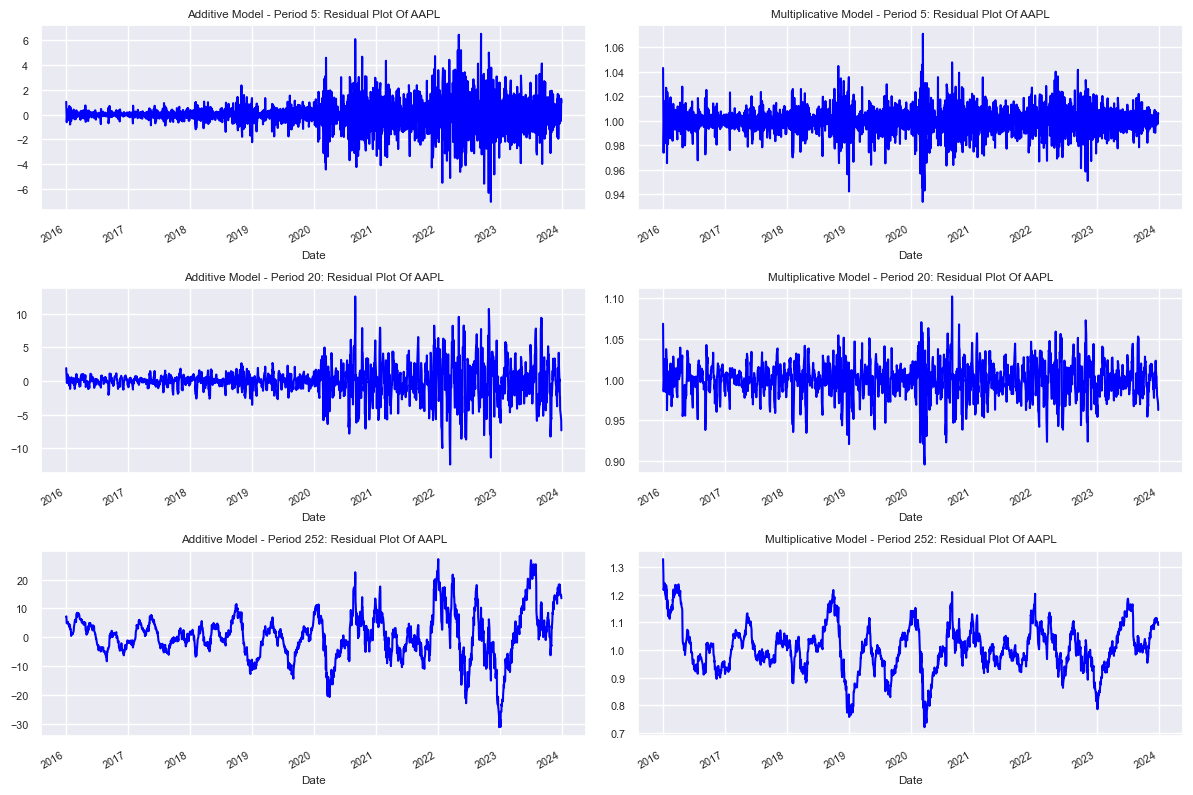

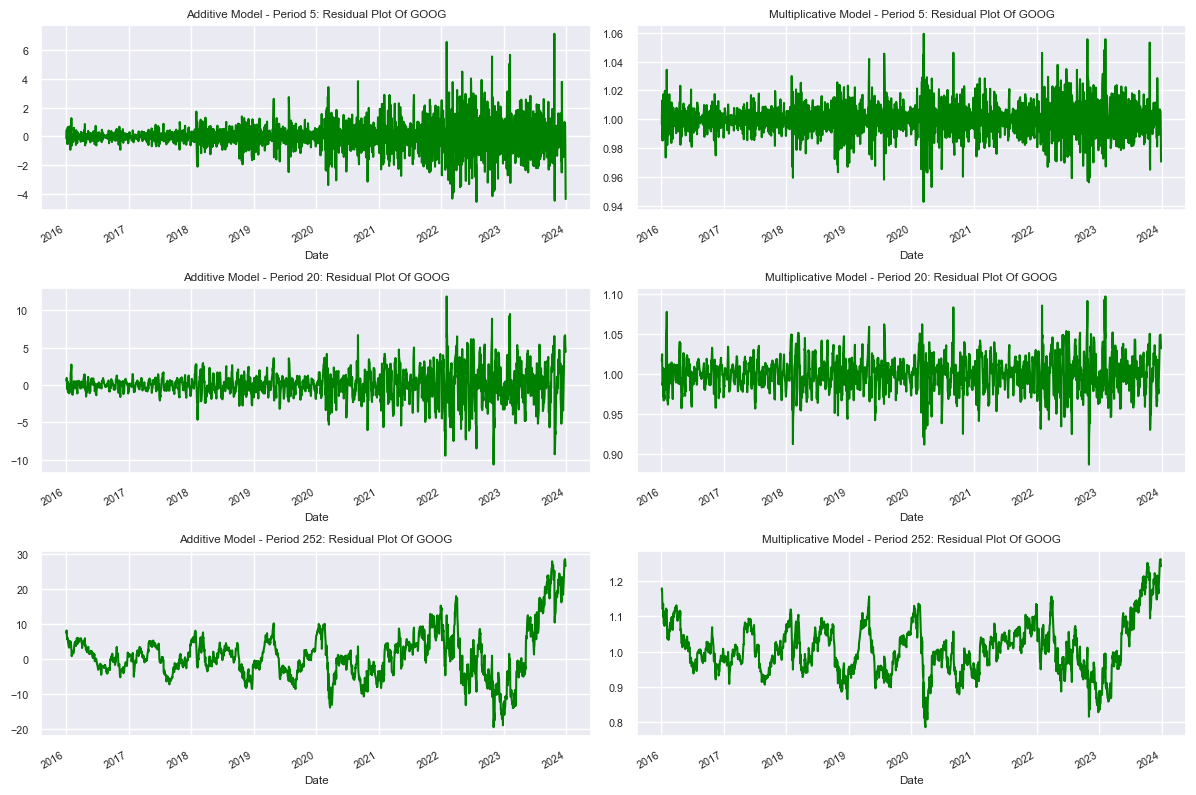

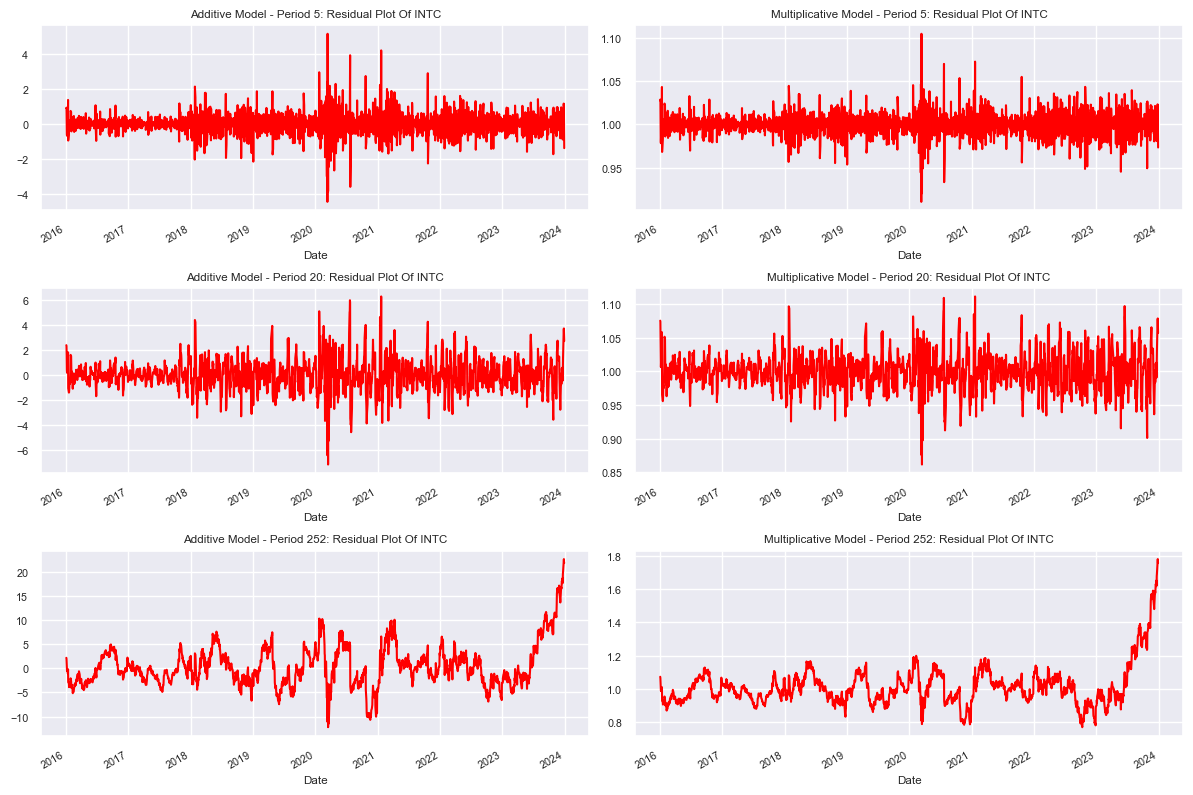

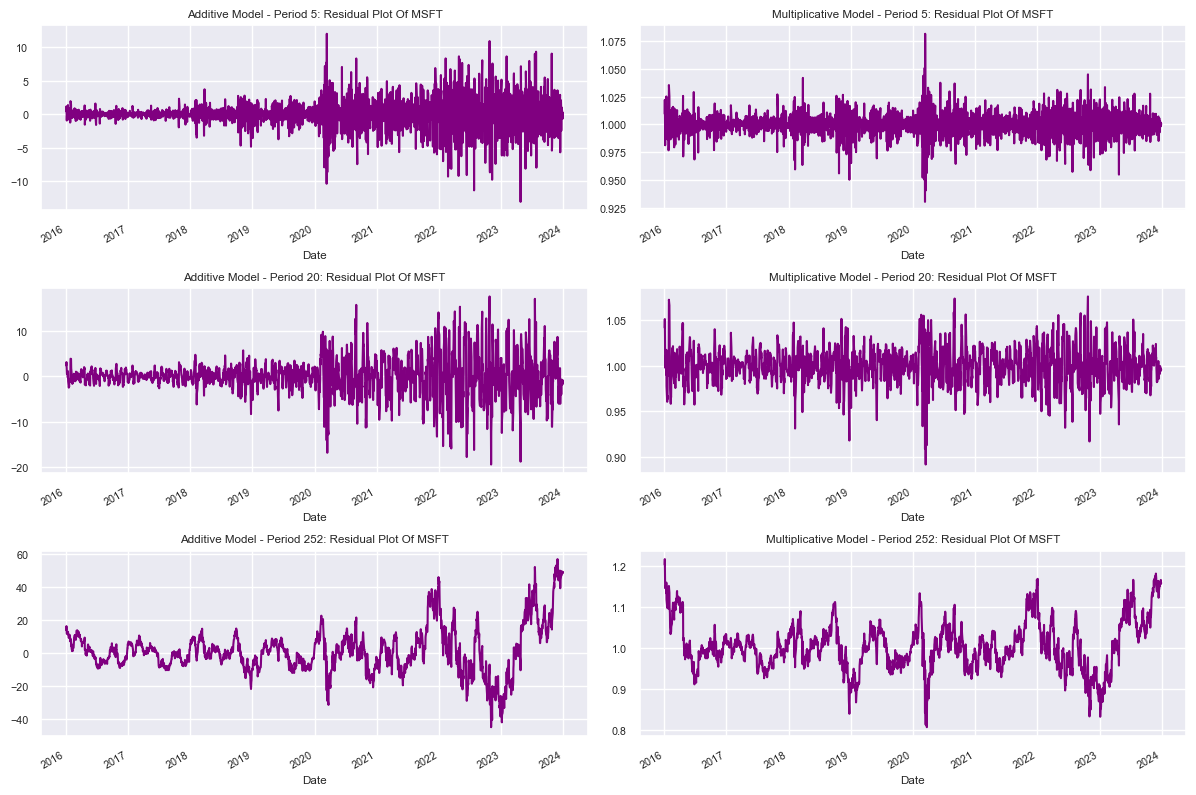

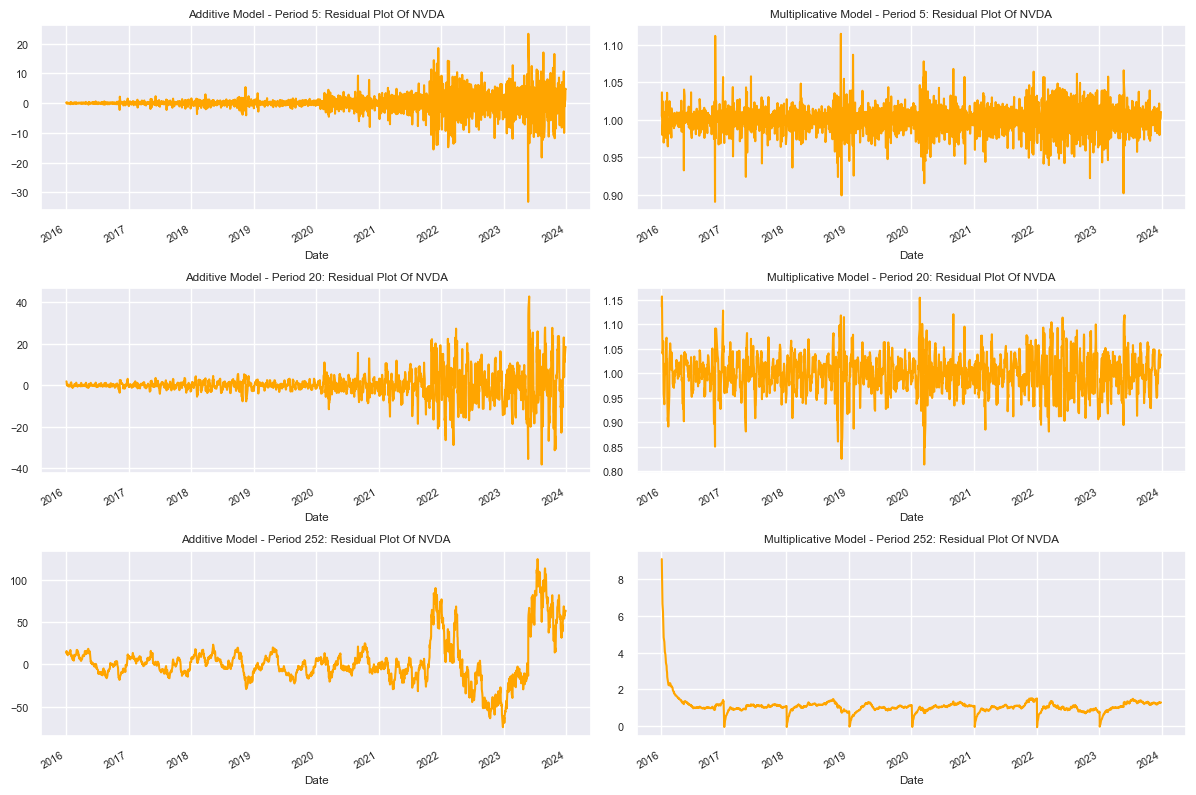

In [18]:
adfPeriod= decomposition(data, [5,20,252])

In [19]:
def highlight_row(row):
    # Define conditions for highlighting
    pval = row['pVal']
    critivalVal_5 = row['criticalVal'].get('5%', '')  # Use .get() to safely access the dictionary
    radf_statistics = row['adf_statistics']
    
    # Check condition for highlighting
    if (pval <= 5e-2) and (critivalVal_5 > radf_statistics):
        return ['background-color: lightblue'] * len(row)
    else:
        return [''] * len(row)

# Define scientific notation function
def scientific_notation(val):
    if isinstance(val, dict):  # Check if val is a dictionary
        return ', '.join(f'{key}: {value:.2e}' for key, value in val.items())  # Format dictionary elements
    else:
        return f'{val:.2e}'  # Format non-dictionary values


periodStat=pd.concat({k: pd.DataFrame(v).T for k, v in adfPeriod.items()}, axis=0)
periodStat.columns=['adf_statistics','pVal','usedLag','nObs','criticalVal','icbest']
styled_df = periodStat.style.apply(highlight_row, axis=1).format(scientific_notation)

highlighted_rows = periodStat[(periodStat['pVal'] <= 5e-2) & (periodStat['criticalVal'].apply(lambda x: x.get('5%', 0)) > periodStat['adf_statistics'])]

min_indices = highlighted_rows.groupby(level=0).pVal.idxmin()
for idx in min_indices:
    styled_df.set_properties(**{'color': 'yellow'}, subset=pd.IndexSlice[idx])
styled_df

<Figure size 640x480 with 0 Axes>

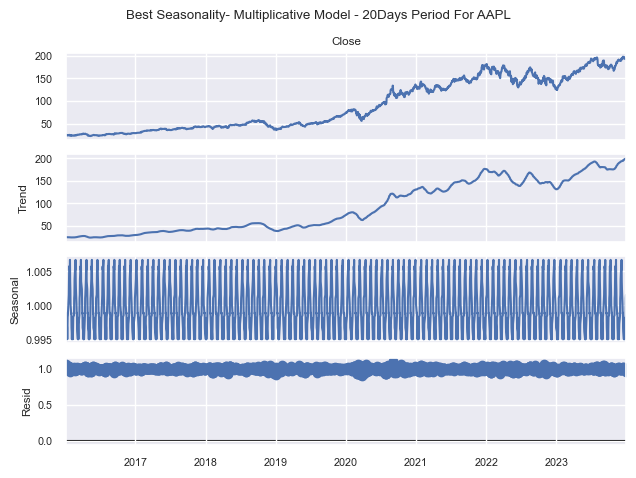

<Figure size 640x480 with 0 Axes>

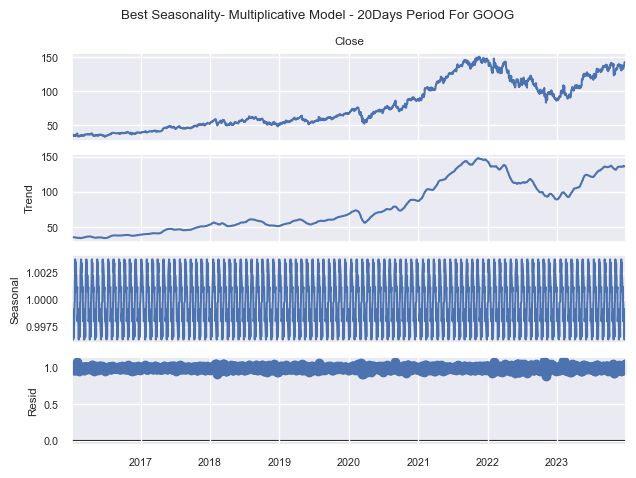

<Figure size 640x480 with 0 Axes>

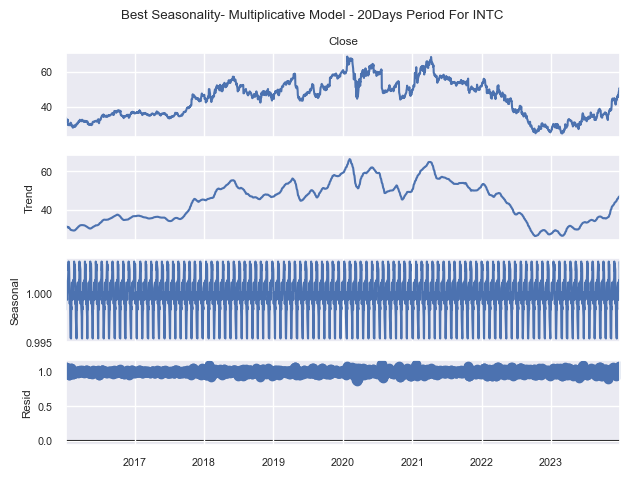

<Figure size 640x480 with 0 Axes>

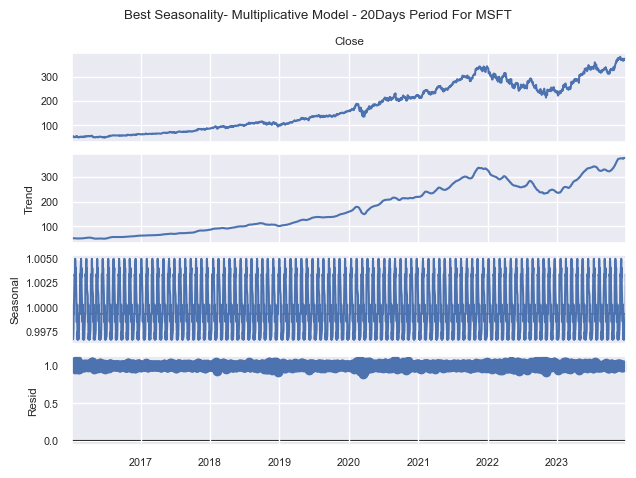

<Figure size 640x480 with 0 Axes>

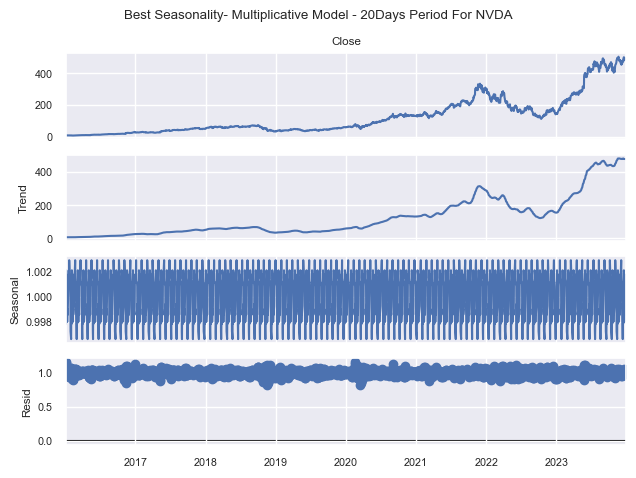

In [20]:
for tickerS in data['Ticker'].unique().tolist():
    df= data.loc[data['Ticker'] == tickerS]
    bestP= seasonal_decompose(df.Close, model='multiplicative', 
                                            period=20, extrapolate_trend='freq')
    fig = plt.figure()
    fig = bestP.plot()
    plt.suptitle(f"Best Seasonality- Multiplicative Model - 20Days Period For {tickerS}")
    plt.tight_layout()
    plt.show()

In [24]:
def test_stationarity(timeseries, tickerS, col):

    #Determing rolling statistics - remove noise by taking past 12 months close price 
    #and give a mean value at every point further ahead 
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation of {tickerS} - {col}')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )

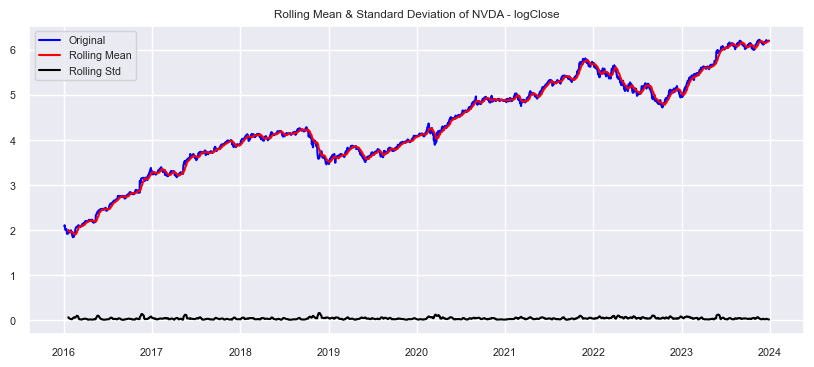

Results of Dickey-Fuller Test:
Test Statistic                   -1.447629
p-value                           0.559242
#Lags Used                        8.000000
Number of Observations Used    2003.000000
Critical Value (1%)              -3.433619
Critical Value (5%)              -2.862984
Critical Value (10%)             -2.567539
dtype: float64




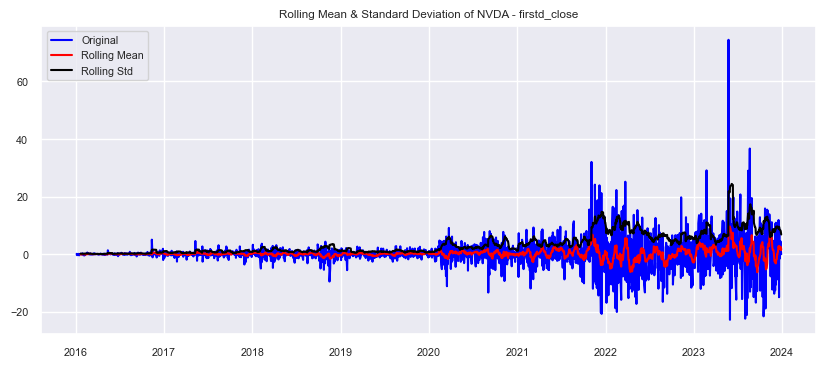

Results of Dickey-Fuller Test:
Test Statistic                -7.945245e+00
p-value                        3.233058e-12
#Lags Used                     2.600000e+01
Number of Observations Used    1.984000e+03
Critical Value (1%)           -3.433650e+00
Critical Value (5%)           -2.862998e+00
Critical Value (10%)          -2.567546e+00
dtype: float64




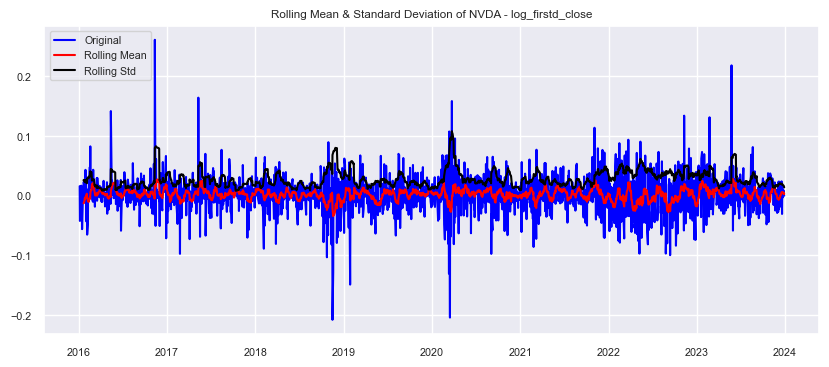

Results of Dickey-Fuller Test:
Test Statistic                -1.614574e+01
p-value                        4.625359e-29
#Lags Used                     7.000000e+00
Number of Observations Used    2.003000e+03
Critical Value (1%)           -3.433619e+00
Critical Value (5%)           -2.862984e+00
Critical Value (10%)          -2.567539e+00
dtype: float64




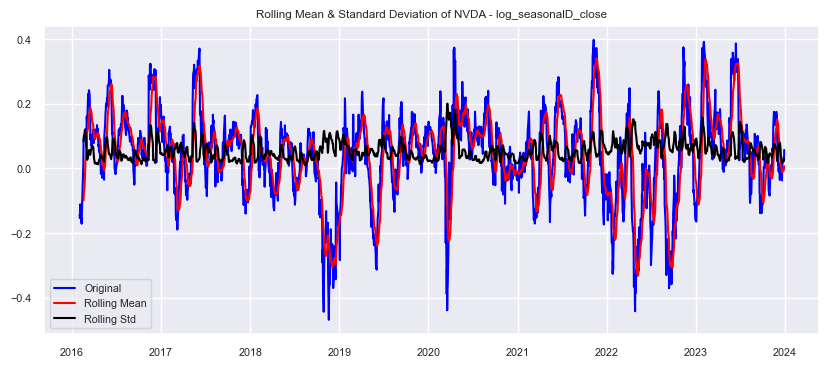

Results of Dickey-Fuller Test:
Test Statistic                -5.848027e+00
p-value                        3.644546e-07
#Lags Used                     2.000000e+01
Number of Observations Used    1.971000e+03
Critical Value (1%)           -3.433672e+00
Critical Value (5%)           -2.863008e+00
Critical Value (10%)          -2.567551e+00
dtype: float64




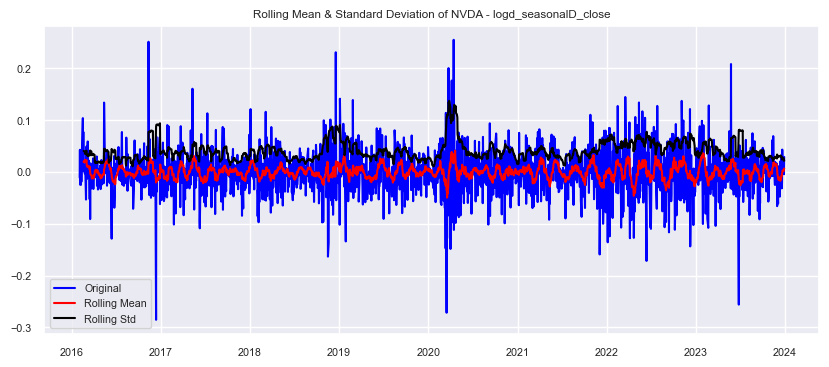

Results of Dickey-Fuller Test:
Test Statistic                -1.640681e+01
p-value                        2.606410e-29
#Lags Used                     1.900000e+01
Number of Observations Used    1.971000e+03
Critical Value (1%)           -3.433672e+00
Critical Value (5%)           -2.863008e+00
Critical Value (10%)          -2.567551e+00
dtype: float64




In [26]:
#taking log transformation to eliminate the trend 
nvda['logClose']= np.log(nvda.Close)
nvda['firstd_close']= nvda.Close - nvda.Close.shift(1)
nvda['log_firstd_close']= nvda.logClose - nvda.logClose.shift(1)
nvda['log_seasonalD_close']= nvda.logClose - nvda.logClose.shift(periods=20)
nvda['logd_seasonalD_close']= nvda.log_firstd_close - nvda.log_firstd_close.shift(periods=20)
#nvda['20lag_detrend']= nvda.detrend_close- nvda.detrend_close.shift(periods=20)
for col in ['logClose','firstd_close','log_firstd_close','log_seasonalD_close', 'logd_seasonalD_close']:
    for tickerS in nvda['Ticker'].unique().tolist():
        df= nvda.loc[nvda['Ticker'] == tickerS]
        test_stationarity(df[col].dropna(), tickerS, col)
        print('\n')

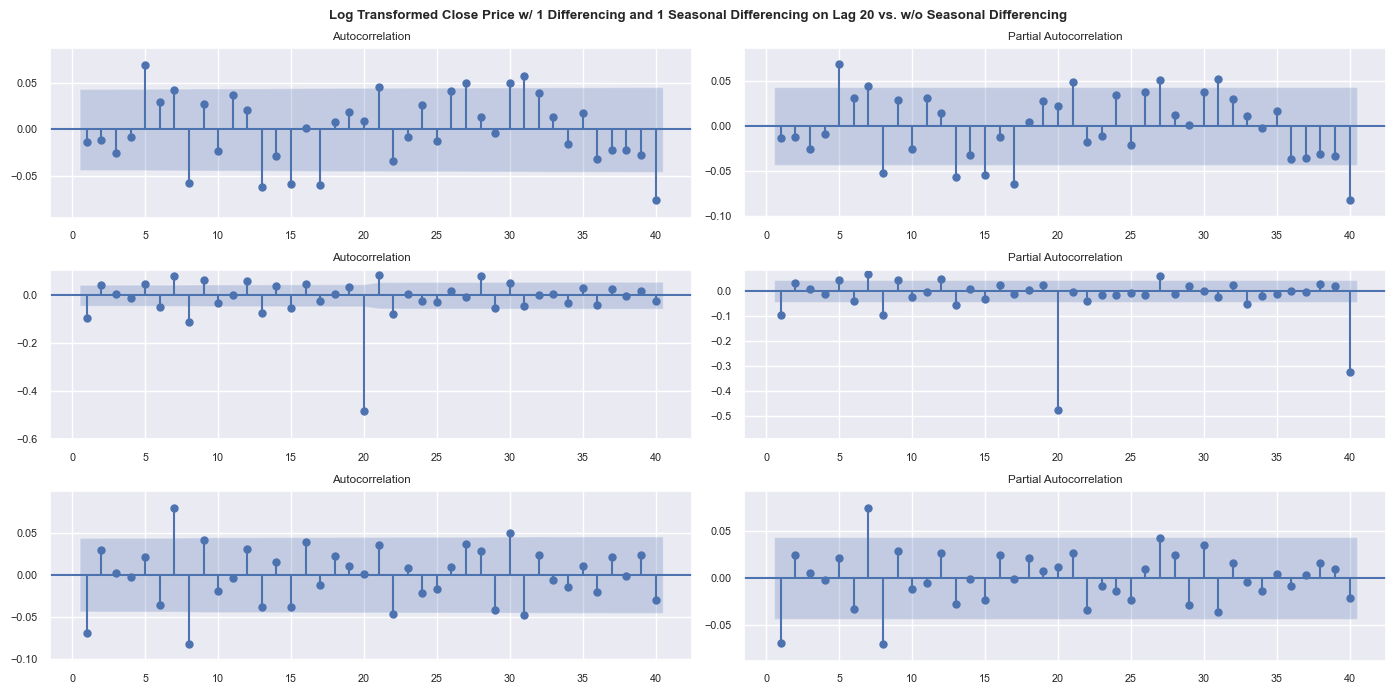

In [29]:
# overdifferenced since the first lag of acf plot is negatitve, 
# adding and moving averae to the model with order 2, since that is the lag where the acf plot cus off. 
import statsmodels.api as sm
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
plt.suptitle('Log Transformed Close Price w/ 1 Differencing and 1 Seasonal Differencing on Lag 20 vs. w/o Seasonal Differencing', weight='bold')
sm.graphics.tsa.plot_acf(nvda['firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0][0])
sm.graphics.tsa.plot_pacf(nvda['firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0][1])

sm.graphics.tsa.plot_acf(nvda['logd_seasonalD_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1][0])
sm.graphics.tsa.plot_pacf(nvda['logd_seasonalD_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1][1])

sm.graphics.tsa.plot_acf(nvda['log_firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[2][0])
sm.graphics.tsa.plot_pacf(nvda['log_firstd_close'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[2][1])

#d1,D1
plt.tight_layout()
plt.show()

In [30]:
from pmdarima.arima import ndiffs,nsdiffs

kpss_diffs = ndiffs(nvda.logClose, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(nvda.logClose, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Estimated differencing term: {n_diffs}")

ch_Sdiffs = nsdiffs(nvda.logClose, m=20, test='ch',max_D=6)
print(f"Estimated seasonaldifferencing term: {ch_Sdiffs}")

Estimated differencing term: 1
Estimated seasonaldifferencing term: 0


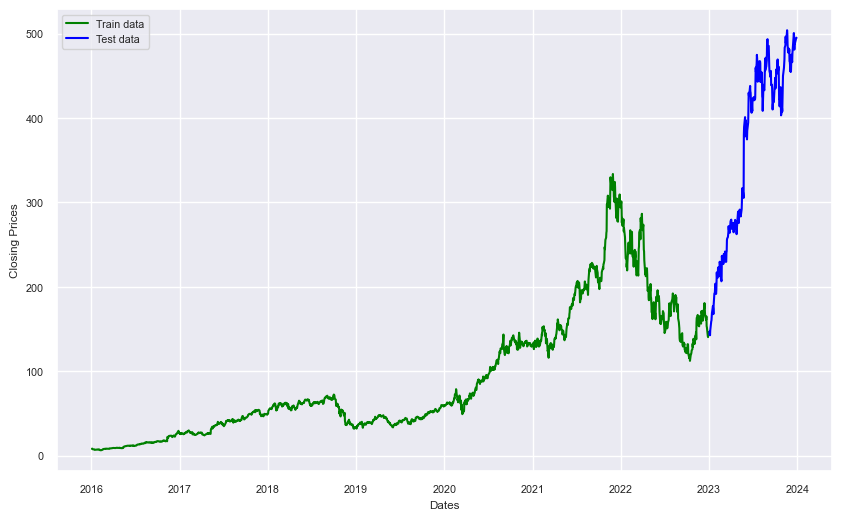

In [32]:
#x=nvdal.close
train,test=nvda[nvda.index.year<2023],nvda[nvda.index.year>=2023]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train.Close, 'green', label='Train data')
plt.plot(test.Close, 'blue', label='Test data')
plt.legend()

In [34]:
train = train[train.columns[:5]]
test = test[test.columns[:5]]
train

Price      Ticker        Open        High         Low       Close
Date                                                             
2016-01-04   NVDA    8.072500    8.145000    8.010000    8.092500
2016-01-05   NVDA    8.245000    8.360000    8.125000    8.222500
2016-01-06   NVDA    8.087500    8.125000    7.790000    7.882500
2016-01-07   NVDA    7.685000    7.737500    7.470000    7.570000
2016-01-08   NVDA    7.667500    7.675000    7.392500    7.407500
...           ...         ...         ...         ...         ...
2022-12-23   NVDA  151.960007  153.389999  148.830002  152.059998
2022-12-27   NVDA  150.740005  151.000000  140.559998  141.210007
2022-12-28   NVDA  139.270004  142.619995  138.839996  140.360001
2022-12-29   NVDA  144.020004  146.830002  142.270004  146.029999
2022-12-30   NVDA  143.339996  146.289993  142.330002  146.139999

[1762 rows x 5 columns]

In [ ]:
import warnings 
warnings.filterwarnings('ignore')
exogenous_features = ['high', 'low','open' ]
model = sm.tsa.arima.ARIMA(endog=train['close'], exog=train[exogenous_features], order=(1, 1, 1))          #(p,d,q)
model_fit = model.fit()
model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,1,1)[20]             : AIC=inf, Time=13.95 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=11000.302, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=10582.796, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=inf, Time=4.62 sec
 ARIMA(1,1,0)(0,1,0)[20]             : AIC=10995.026, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[20]             : AIC=10358.286, Time=2.55 sec
 ARIMA(1,1,0)(2,1,1)[20]             : AIC=inf, Time=10.14 sec
 ARIMA(1,1,0)(1,1,1)[20]             : AIC=inf, Time=6.00 sec
 ARIMA(0,1,0)(2,1,0)[20]             : AIC=10359.969, Time=2.69 sec
 ARIMA(2,1,0)(2,1,0)[20]             : AIC=10360.041, Time=4.17 sec
 ARIMA(1,1,1)(2,1,0)[20]             : AIC=10360.081, Time=6.23 sec
 ARIMA(0,1,1)(2,1,0)[20]             : AIC=10358.206, Time=3.15 sec
 ARIMA(0,1,1)(1,1,0)[20]             : AIC=10582.735, Time=1.24 sec
 ARIMA(0,1,1)(2,1,1)[20]             : AIC=inf, Time=10.80 sec
 ARIMA(0,1,1)(1,1,1)[20]        

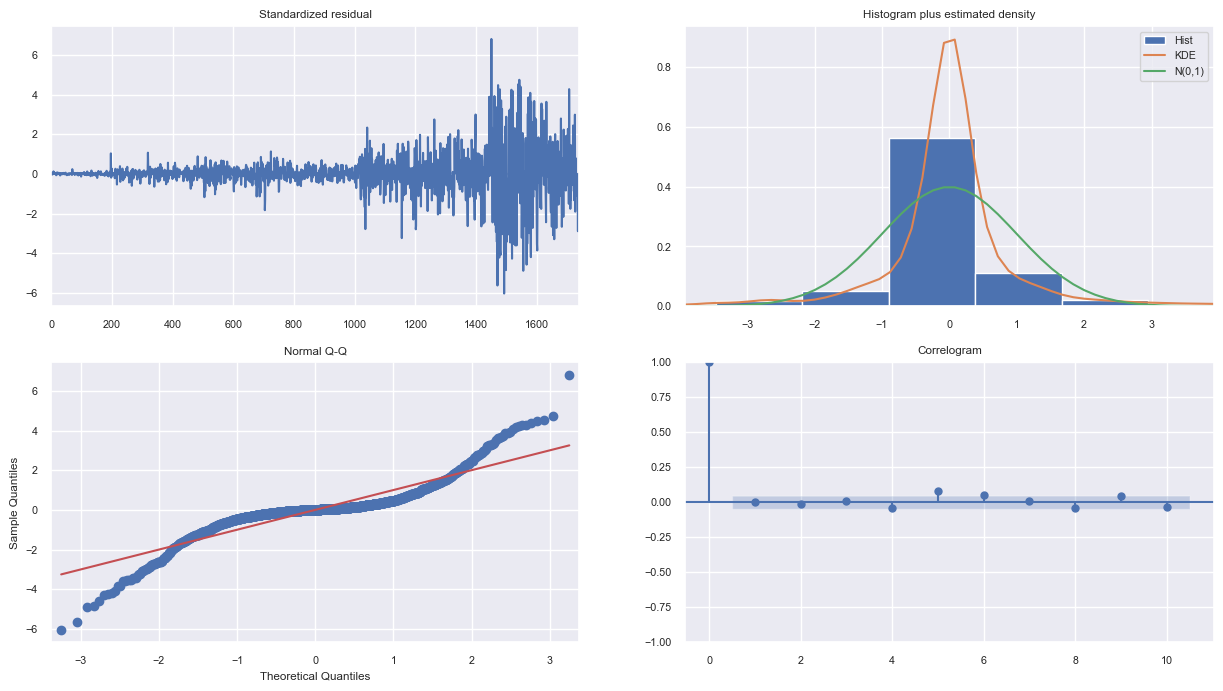

In [37]:
import pmdarima as pmd
#Best model:  ARIMA(0,1,0)(3,1,1)[20]  
model_autoARIMA=pmd.auto_arima(train.Close,
                      max_p=5, max_q=5, # maximum p and q
                      m=20,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
fitted= model_autoARIMA.fit(train.Close)
print(fitted.summary())
fitted.plot_diagnostics(figsize=(15,8))
plt.show()

In [39]:
import statsmodels.api as sm
model = ARIMA(train.Close, order=(0,1,1), seasonal_order=(2, 1, 0, 20),)
fitted = model.fit()
print(fitted.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1762
Model:             ARIMA(0, 1, 1)x(2, 1, [], 20)   Log Likelihood               -5175.103
Date:                           Fri, 26 Apr 2024   AIC                          10358.206
Time:                                   18:09:48   BIC                          10380.055
Sample:                                        0   HQIC                         10366.285
                                          - 1762                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0473      0.013     -3.558      0.000      -0.073      -0.021
ar.S.L20      -0.6245      0.010    -63.751

In [40]:
from sklearn.metrics import mean_squared_error
training_data = train['Close'].values
test_data = test['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(0,1,1), seasonal_order=(2, 1, 0, 20) )
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 139.75572576482446


In [41]:
MSE_error

139.75572576482446

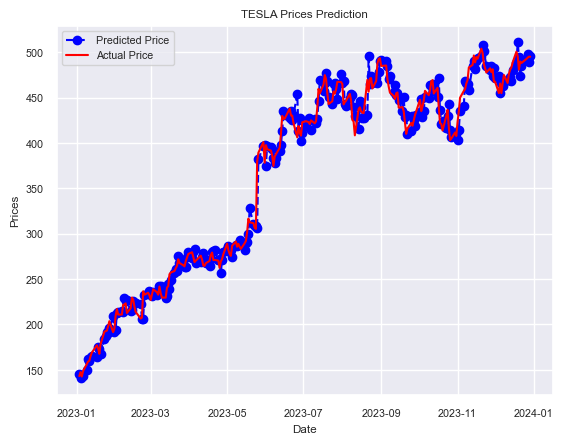

In [42]:
test_set_range = test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
#plt.xticks(np.arange(881,1259,50), aapl.Date[881:1259:50])
plt.legend()
plt.show()

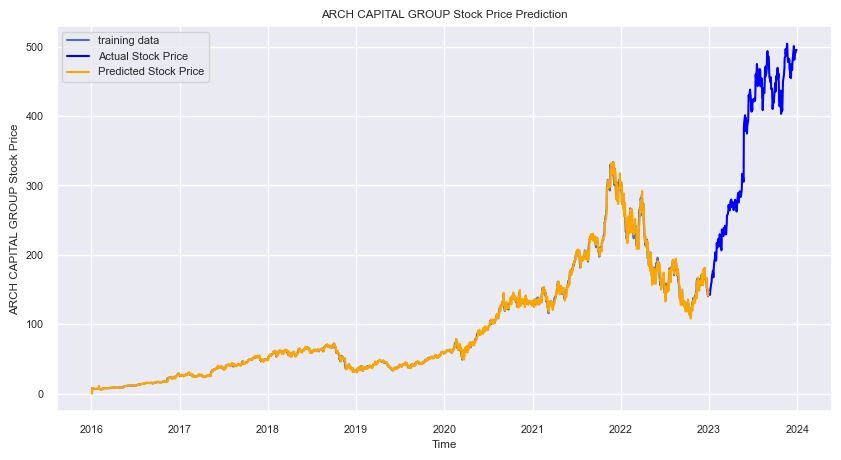

In [44]:
fc= fitted.predict(n_periods=len(test))

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train.Close, label='training data')
plt.plot(test.Close, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')

plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model = sm.tsa.arima.ARIMA(train, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

history = [x for x in train]
predictions = list()

output = fitted.forecast()
yhat = output
predictions.append(yhat)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
test.plot()
predictions.plot(color='red')
plt.show()

In [ ]:
fc, se, conf = fitted.forecast(321, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model=SARIMAX(endog=tsla.seasonal_first_diff_close.dropna(), 
              order=(0,0,1), seasonal_order=(2,0,0,20), trend='ct').fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [ ]:
model.summary()

In [ ]:
sarimax_model = SARIMAX(endog=tslaDiffL.close.dropna().values, trend='ct',
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [ ]:
print(sarimax_model.summary())

In [ ]:
from statsmodels.tsa.stattools import acf, q_stat
from scipy.stats import probplot, moment
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
plot_correlogram(pd.Series(sarimax_model.resid))

In [ ]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = -1.0

'''for index, row in df.iterrows():
    if row["close"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["close"] < 0:
        df.loc[index,"Signal"] = 0'''
        
'''for index, row in df.iterrows():
    if row["vwap"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["vwap"] < 0:
        df.loc[index,"Signal"] = 0.0'''
        
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["close"].shift(-1)

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(10)

In [ ]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

for column in lstColumns:
    display(df.hvplot.scatter(y='FutureMid',x=column))
    dfopt=df[['FutureMid',column]]
    display(dfopt.corr())

In [ ]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

In [ ]:
df

In [ ]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['10MASlope','2MASlope','CloseDiff3MA']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=48)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

display(X_test_scaled)

In [ ]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


In [ ]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression()

model=logModel.fit(X_train_scaled, y_train)
log_pred=logModel.predict(X_test_scaled)

log_testing_report = classification_report(y_test, log_pred)

print(log_testing_report)


In [ ]:
4991/9151

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [ ]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

In [ ]:
X_test

In [ ]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    